<h1>FINM 37400, Winter 2023, Homework 4</h1>

Homework Group B1:
<ul>
<li>Qayum Khan</li>
<li>Madison Rusch</li>
<li>Timothy Taylor</li>
<li>Minxing "Mark" Zhao</li>
</ul>

In [2]:
# import treasury_cmds as hendricks # library of Prof Hendricks; give credit where it's due!

import pandas as pd
pd.set_option("display.precision", 4)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from math import sqrt
import numpy as np
import seaborn as sbn

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import matplotlib.dates as mdates

from scipy.optimize import minimize, fsolve
from scipy import interpolate

# SECTION 1 : HBS Case : The Information Content of the Yield Curve

# QUESTION 1 : The Term Spread

The <b>term spread</b> is the difference of yield-to-maturities between a longer maturity bond and a shorter maturity bond from the same issuer.<br>
Normally it's positive and the yield curve is called <b>inverted</b> if this difference is negative.

For this HBS case, the type are US treasuries and the term spread is being taken to be the YTM of the 10-yr treasury minus the YTM of the 13-wk treasury.

The economist Arturo Estrella at the New York Federal Reserve Bank states <i>"the yield curve has a stellar record, predicting every US recession since 1950; its only 'false' signal foresaw a recession in all but name&mdash;the credit crunch and slowdown in production of 1967."</i>  The slope of the term spread, as a percentage change, is more of a predictor of recession than the actual level.

However, for the purpose of a robust predictive signal of real gross domestic product (GDP), the month-over-month change is most important.  Sharp increases of the term spread are correlated to falling GDP.

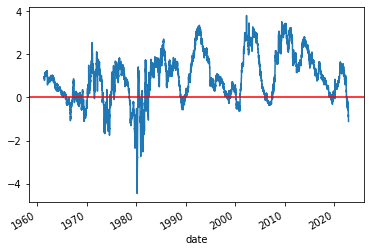

In [6]:
df_yields = pd.read_excel( '../data/yields_2022-11-30.xlsx' ).set_index( 'caldt' )
df_yields.index.name = 'date'
df_yields['spread'] = df_yields[10] - df_yields[1]

df_yields['spread'].plot()
plt.axhline( y=0, color='r' )

In [ ]:
print( f"In particular, on the last date of {df_yields.index[-1].date()}, the 10-1 term spread is {df_yields['spread'][-1]:,.2f}." )

In particular, on the last date of 2022-11-30, the 10-1 term spread is -1.11.


Indeed, the times when the 10-1 spread (here, using 1-yr instead of 13-wk) were negative correspond to the USA's recessions, so negative economic growth (decreasing GDP):
https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States#Great_Depression_onward_(1929%E2%80%93present)

# QUESTION 2 : The Term Premium

According to the definition of Brian Sack of the New York Federal Reserve's Financial Markets Group, the <b>term premium</b> is the "drift" in the 10-yr treasury YTM rate from the unweighted average of the current 1-yr treasury and the expected value of the next 9 1-yr treasuries.

In Equation (1), it's added to correct error in this average of time-t expected values and so it is time-dependent and not constant.  Solving for this term premium, we see that $$\mathrm{tp}_t = \mathbb{E}_t\left[ i^{10}_t - \frac{1}{10} \sum_{j=0}^9 i^1_{t+j} \right],$$ so it is reminiscent of a "premium" of a linear pricing factor model with these fixed loadings of one $1$ and ten $-1/10$ on the stochastic processes $i^{10}_\bullet$ and $i^1_{\bullet+j}$, respectively.

Equation (2) expresses Equation (1) in terms of differences of the 10-1 spread and inter-maturity spreads &mdash; notice the magical telescoping sum:
$$ \mathrm{tp}_t = \mathbb{E}_t \left[ \left(i^{10}_t - i^1_t\right) - \sum_{j=1}^9 (1-0.1 j) \left( i^1_{t+j} - i^1_{t+j-1} \right) \right].$$

Sack had observed the "term premium" to show there is some sort of trend/drift in the differences used for predicting recessions.

This complicates the "term spread" discovered by Estrella, in the sense that a decrease in $\mathrm{tp}_t$ meant a tightening of the term spread $i^{10}_t - i^1_t$.

# QUESTION 3 : Predictivity

<i>Suppose the term premium is zero.</i>

If the yield curve is upward sloping (that is, the spread $i^{10}_t - i^1_t$ is increasing sharply), then by our 2nd equation above, we expect a cumulative increase in the the future spreads of interest rates between consecutive back-to-back 1-yr treasuries.

In this case, we have a replication of the 10-1 spread by nine consecutive 1-1 spreads.  The risk in the sense of volatility (that is, standard deviation) of the 10-1 spread is decomposed as a weighted sum of the volatilities of the 1-1 spreads, asssuming that these nine differences are independent of each other.

Yes, with the sharp increase in the 10-1 spread, the recent rolling volatility has increased, but it's compensated by the increased volatilities of the nine 1-1 spreads.

<i>Suppose the term premium increases by 3%; that is, $\mathrm{tp}_t - \mathrm{tp}_s = 0.03$ for the time period $[s,t]$.</i>

If the yield curve is upward sloping during $[s,t]$, then we still expect a cumulative increase in 1-1 spreads during $[s,t]$ but less so, since $0.03$ of that is being absorbed by the $\mathrm{tp}_\bullet$ trendline, so the 1-1 spreads are flatter than the 10-1 spread.

In this case, we no longer have a replication of the 10-1 spread by the nine consecutive 1-1 spreads.  The volatility of the 10-1 spread is higher due the recent rolling volatility of $\mathrm{tp}_\bullet$, so it is riskier to hold the 10-1 spread than the nine 1-1 spreads weighted as in our 2nd equation.

# SECTION 2 : Calculating Forwards

In [ ]:
# Do some data wrangling to get in a usable format for the <hendricks> library.
df_rates = pd.read_excel( 'selected_treasury_rates.xlsx' ).set_index( 'KYTREASNO' )
df_rates.rename( columns={ 'maturity date':'TMATDT', 'maturity':'TTM', 'coupon rate':'TCOUPRT', 'ytm':'YTM' }, inplace=True )

# For simplicity, we'll CONFLATE 30 March with 31 March, so that the cashflow matrix doesn't have separate columns for them.
df_rates.replace( { pd.Timestamp( str(year)+'-03-31' ):pd.Timestamp( str(year)+'-03-30' ) for year in range(2015,2030) }, inplace=True )
df_rates['CALDT'] = pd.Timestamp( '2022-03-30' ) 
df_rates # Notice that the TTM = "time to maturity" are not all multiples of 0.5, so later we'll need to REGULARIZE via interpolation.

,issue date,TMATDT,TTM,TCOUPRT,price,YTM,CALDT
KYTREASNO,,,,,,,
206896,2015-09-30,2022-09-30,0.5010,1.750,100.3633,0.0101,2022-03-30
207688,2021-03-30,2023-03-30,0.9993,0.125,98.4570,0.0168,2022-03-30
207775,2021-09-30,2023-09-30,1.5003,0.250,97.2188,0.0213,2022-03-30
207077,2017-03-30,2024-03-30,2.0014,2.125,99.5703,0.0233,2022-03-30
207416,2019-09-30,2024-09-30,2.5024,1.500,97.6211,0.0247,2022-03-30
207507,2020-03-30,2025-03-30,3.0007,0.500,94.1758,0.0251,2022-03-30
207256,2018-09-30,2025-09-30,3.5017,3.000,101.5547,0.0251,2022-03-30
207337,2019-03-30,2026-03-30,4.0000,2.250,98.9297,0.0252,2022-03-30
207777,2021-09-30,2026-09-30,4.5010,0.875,93.0430,0.0250,2022-03-30


# QUESTION 1 : Bootstrap the discount factor and plot with discount rates

In [ ]:
rates_boot = hendricks.calc_cashflows(df_rates)
rates_boot # Without the above conflation, we'd have a final coupon a day before (30 March) the face value is paid (31 March)!

,2022-09-30,2023-03-30,2023-09-30,2024-03-30,2024-09-30,2025-03-30,2025-09-30,2026-03-30,2026-09-30,2027-03-30,2027-09-30,2028-03-30,2028-09-30,2029-03-30
KYTREASNO,,,,,,,,,,,,,,
206896,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207688,0.0625,100.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207775,0.1250,0.1250,100.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207077,1.0625,1.0625,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207416,0.7500,0.7500,0.7500,0.7500,100.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207507,0.2500,0.2500,0.2500,0.2500,0.2500,100.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207256,1.5000,1.5000,1.5000,1.5000,1.5000,1.5000,101.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207337,1.1250,1.1250,1.1250,1.1250,1.1250,1.1250,1.1250,101.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207777,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,100.4375,0.0000,0.0000,0.0000,0.0000,0.0000


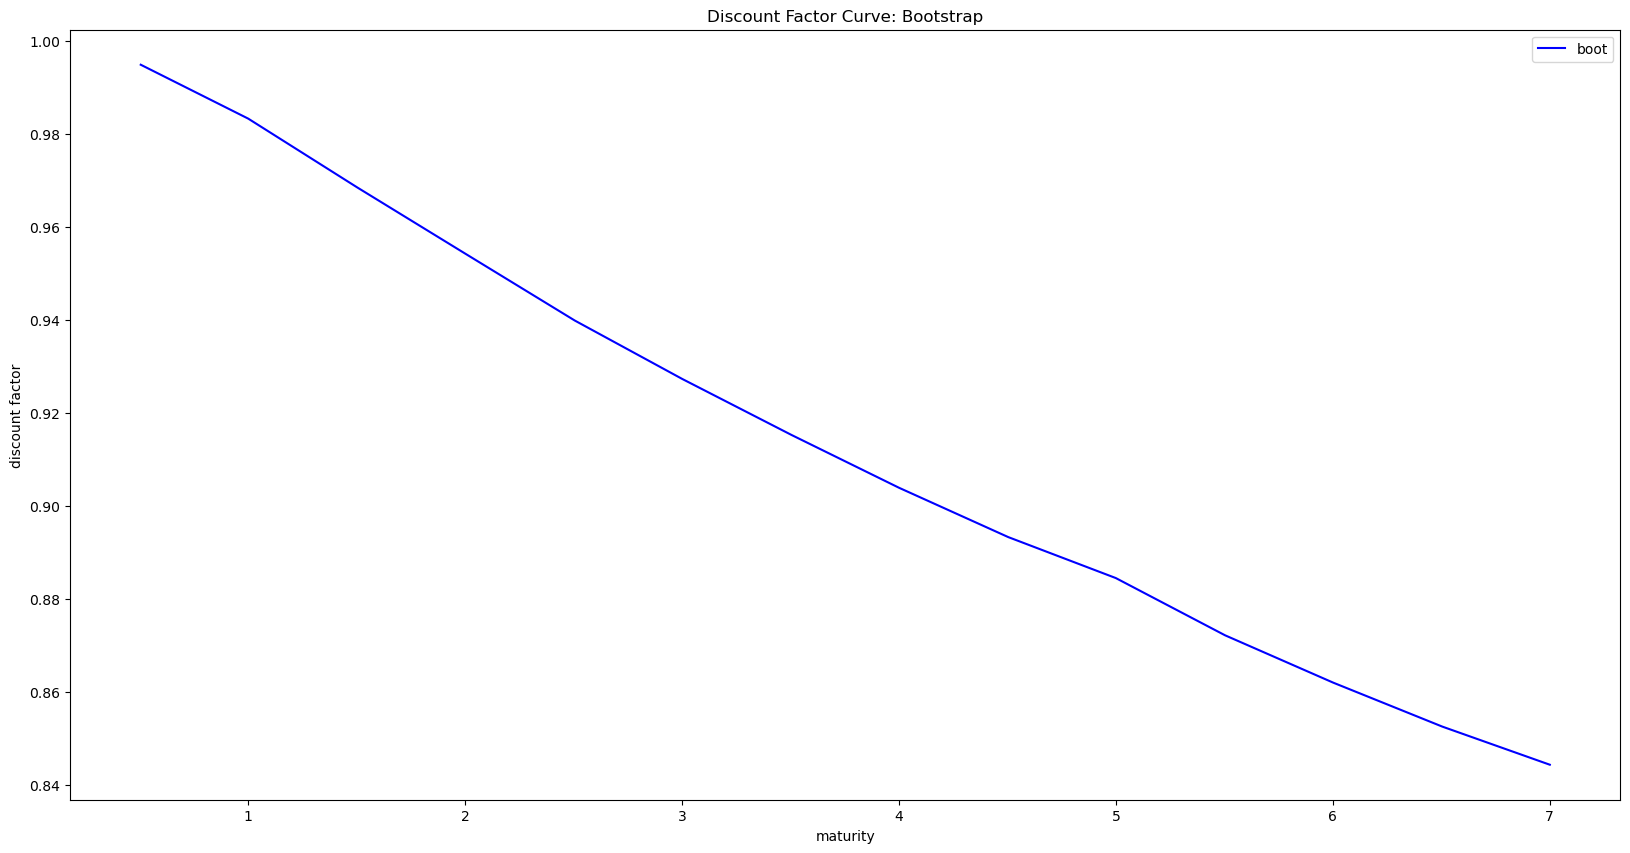

In [ ]:
# The following code is modified from the Qayum's solution to HW1#2.2.

CF_boot = hendricks.filter_treasury_cashflows( rates_boot, filter_maturity_dates=True )

t_current = df_rates['CALDT'].iloc[-1]
prices_boot = df_rates['price'][CF_boot.index]
params_boot = hendricks.estimate_rate_curve( hendricks.bootstrap, CF_boot, t_current, prices_boot )

disc_boot = pd.DataFrame({ 'maturity':params_boot[0], 'boot': params_boot[1] }).set_index('maturity')
disc_boot.plot( ylabel='discount factor', color='b', title='Discount Factor Curve: Bootstrap' )
plt.show()

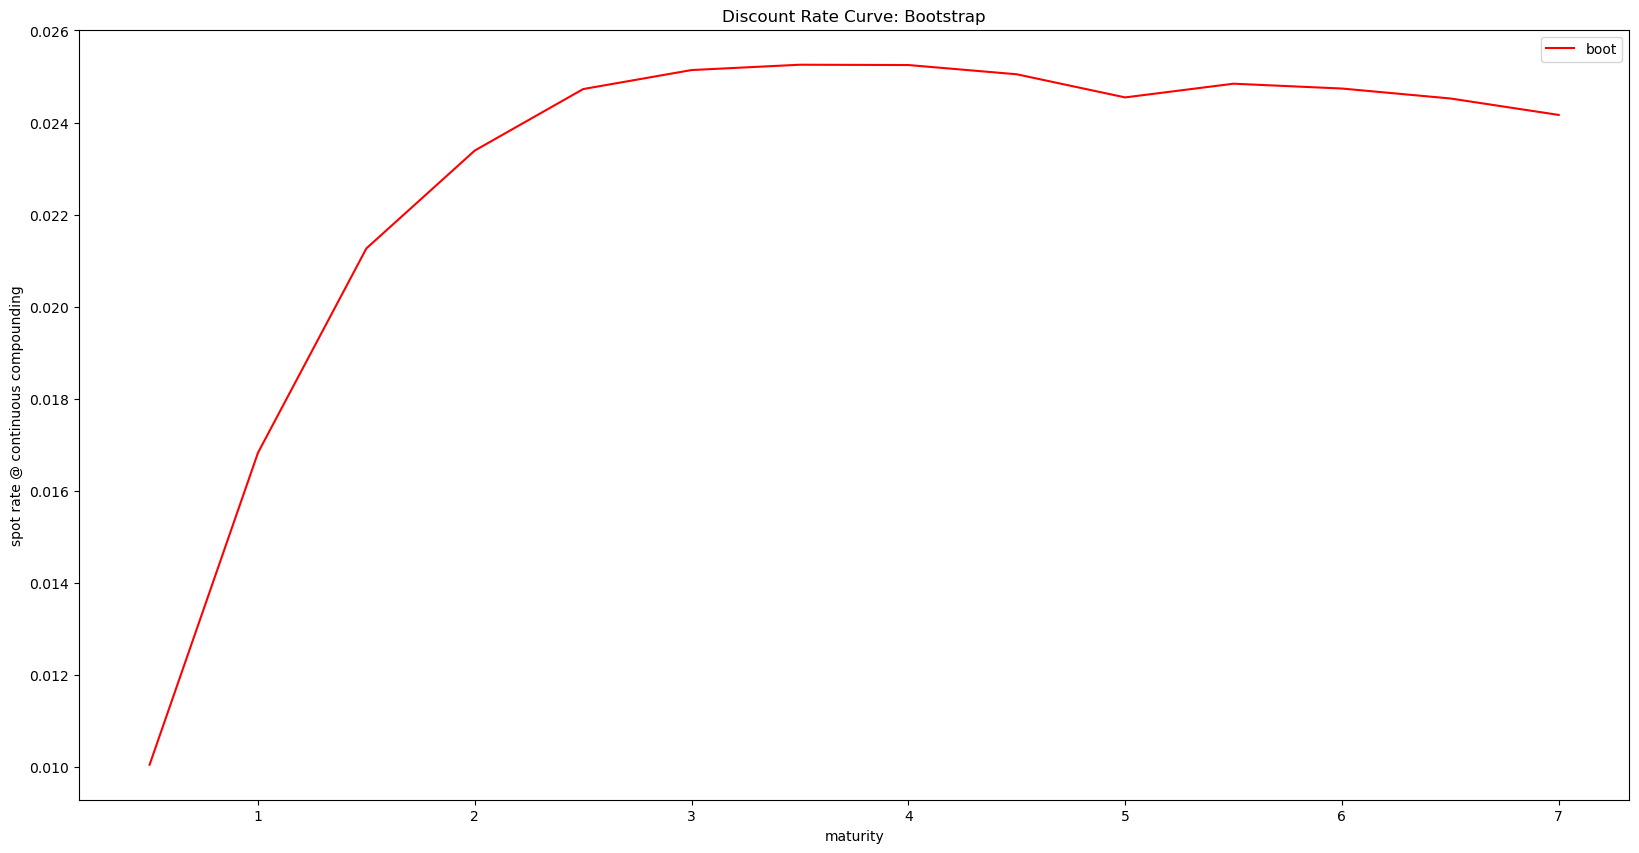

In [ ]:
# Note that the <boostrap> function is just a vectorized version of <discount_to_intrate> with interpolation to EVENLY SPACED maturity dates.
params_boot_reg = 0.5 + np.arange( 0, round(params_boot[0].max()), 0.5 ) # REGULARIZED since listed maturities are not exactly multiples of 0.5
spot_boot_vals = hendricks.bootstrap( params_boot, params_boot_reg )
spot_boot = pd.DataFrame({ 'maturity':params_boot_reg, 'boot': spot_boot_vals }).set_index('maturity')
spot_boot.plot( ylabel='spot rate @ continuous compounding', color='r', title='Discount Rate Curve: Bootstrap' )
plt.show()

# QUESTION 2

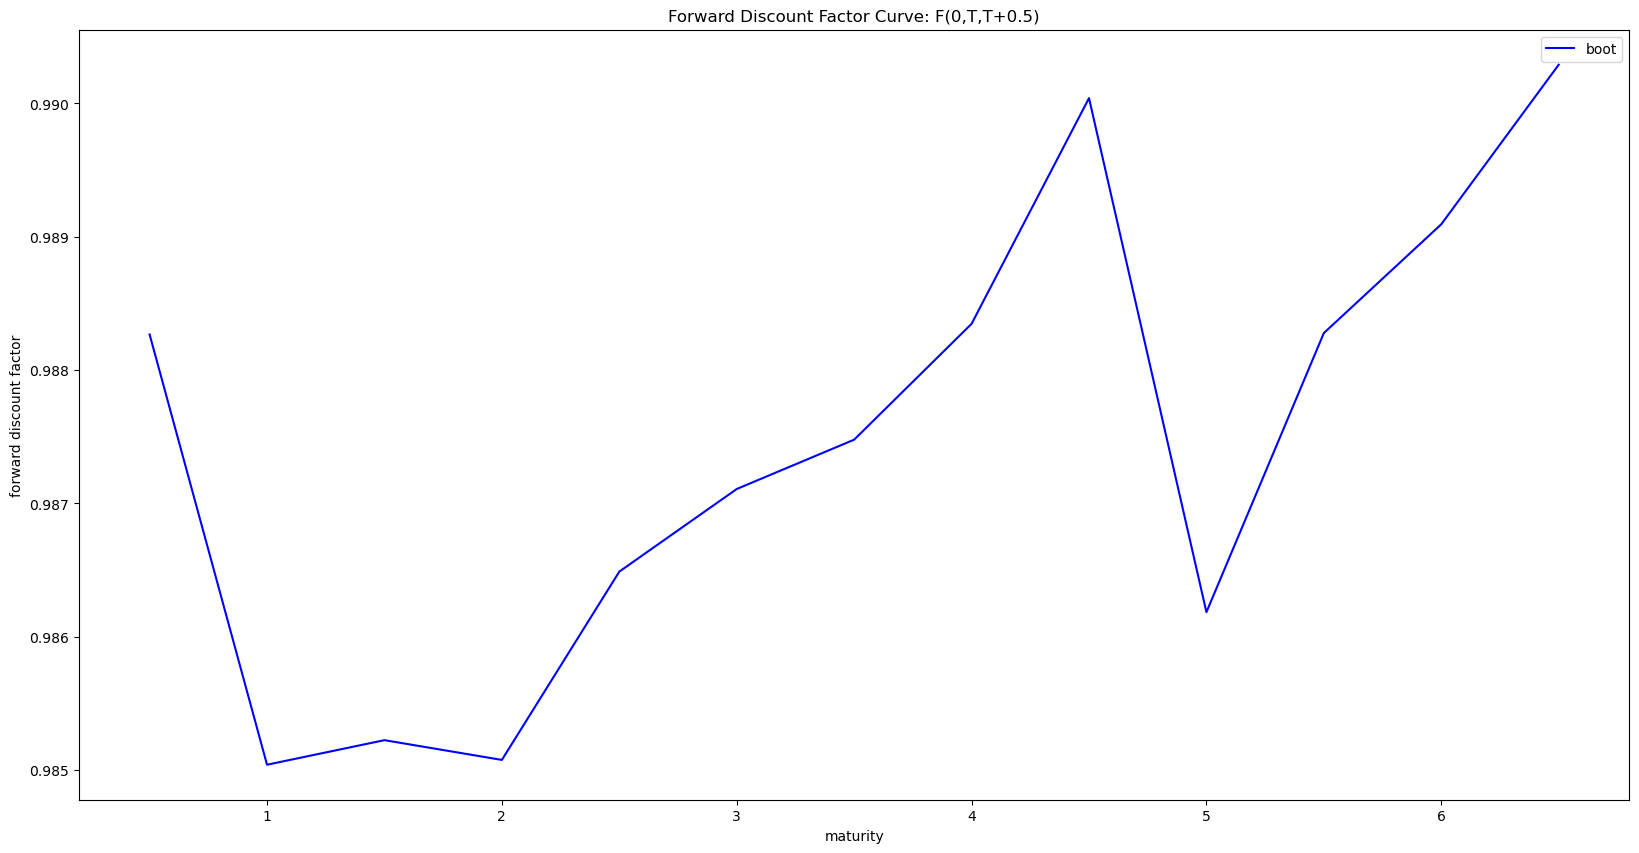

In [ ]:
# We won't use <extract_spot_curves> dict output with key "forward discount", since that code presumes the Nelson--Siegel method instead of plain bootstrap.
disc_boot_vals = np.exp( -spot_boot_vals * params_boot_reg ) # need to use the REGULARIZED version of <disc_boot['boot']>
fwd_disc_boot_vals = np.array( [ disc_boot_vals[i+1]/disc_boot_vals[i] for i in range(len(disc_boot_vals)-1) ] )
fwd_disc_boot = pd.DataFrame({ 'maturity':params_boot_reg[:-1], 'boot': fwd_disc_boot_vals }).set_index('maturity')
fwd_disc_boot.plot( ylabel='forward discount factor', color='b', title='Forward Discount Factor Curve: F(0,T,T+0.5)' )
plt.show()

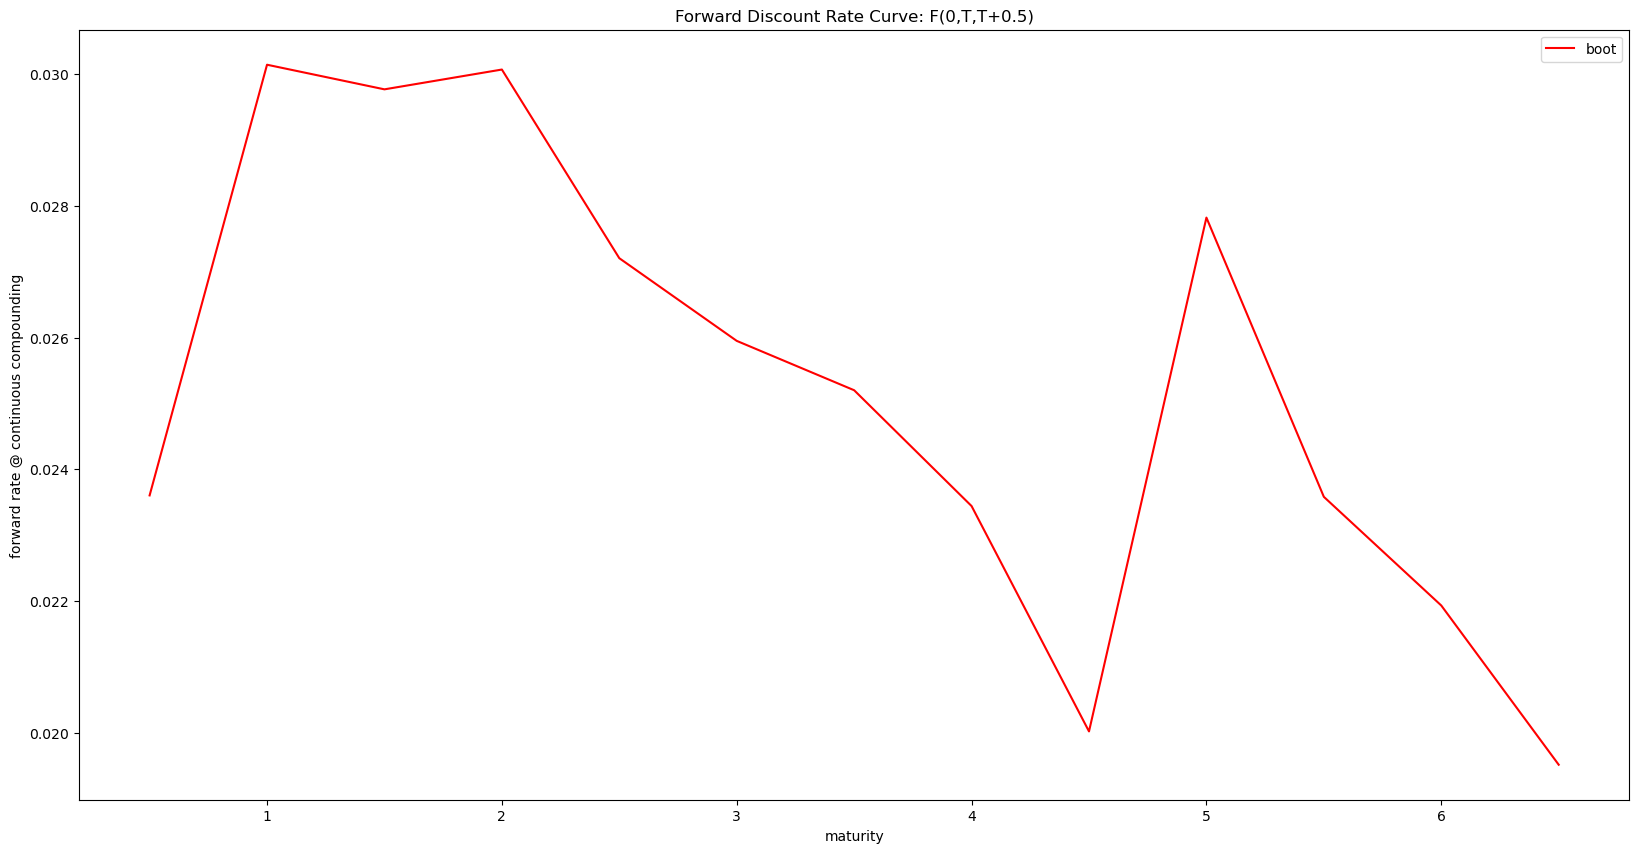

In [ ]:
# We won't use <extract_spot_curves> dict output with key "forward rate", since that code presumes the Nelson--Siegel method instead of plain bootstrap.
fwd_spot_boot_vals = -np.log( fwd_disc_boot_vals ) / 0.5
fwd_spot_boot = pd.DataFrame({ 'maturity':params_boot_reg[:-1], 'boot': fwd_spot_boot_vals }).set_index('maturity')
fwd_spot_boot.plot( ylabel='forward rate @ continuous compounding', color='r', title='Forward Discount Rate Curve: F(0,T,T+0.5)' )
plt.show()

# QUESTION 3

In [ ]:
print( f"The (continuously compounded) forward rate from T1=2 to T2=2.5 is {100 * fwd_spot_boot.loc[2,'boot']:,.2f}%." )

The (continuously compounded) forward rate from T1=2 to T2=2.5 is 3.01%.


In [ ]:
print( f"The (continuously compounded) forward rate from T1=5 to T2=5.5 is {100 * fwd_spot_boot.loc[5,'boot']:,.2f}%." )

The (continuously compounded) forward rate from T1=5 to T2=5.5 is 2.78%.


# QUESTION 4

A forward rate agreement (FRA) between $T_1$ and $T_2$ is similar to a forward loan but instead leverages the capital.  At time $T_1$, the grantor pays the forward rate $f_n(0,T_1,T_2)$ on the notional amount of $N$ dollars, which itself is not exchanged.  At time $T_2$, the grantee reciprocates by paying the spot rate $r_n(T_1,T_2)$.  There will be a winner and a loser to this deal, depending on the prevailing spot rate.  It is similar to a floating-for-fixed interest-rate swap except it's based on the spread between two bonds instead of a single asset bearing interest.  

Since the 6-mo bonds are zero-coupon, the forward discount factor calculated above is used for the no-arbitrage pricing of the FRA as follows, since at most one bond at a time is held: $$ P_\mathrm{fwd}(t,T_1,T_2)  = \$100 \, F(t, T_1, T_2) \quad \forall \; 0 \leqslant t < T_1.$$ 

<i>Note that the three-step outline in the "Forwards" lecture note describes a replication of the FRA for pricing, but it actually is not the actions of the FRA itself!</i>